# Are You Good Enough to Make the kNN Algorithm Work?
## You will be after reading this in-depth guide
<img src='images/neigh.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@suju?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Susanne Jutzeler</a>
        on 
        <a href='https://www.pexels.com/photo/closed-doors-3015714/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

### Setup

In [60]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.impute import SimpleImputer
# Filter warnings
import warnings
warnings.filterwarnings('ignore')

# Visual display
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
rcParams['figure.figsize'] = [12, 9]
rcParams['font.size'] = 16
custom_colors = ['#74a09e','#86c1b2','#98e2c6','#f3c969','#f2a553', '#d96548', '#c14953']
sns.set_palette(custom_colors)

%config InlineBackend.figure_format = 'retina'

### What Is KNN?

### k-Nearest-Neighbors, under the hood

The first thing you should know about the internals of kNN is that it is a lazy algorithm. In machine learning lingo, it means the algorithm has no or extremely short training phase compared to others. Don't get your hopes up yet because speedy training comes with a big drawback.

Generating predictions will be much slower because of how kNN finds the nearest neighbors. In the short training phase, it memorizes all data points. To make a prediction, the algorithm finds the distance between the new sample and every single data point in the dataset. Then, it takes the *k* smallest distances and classifies the new sample depending on the majority of the vote of its neighbors.
<img src='images/1.jpg'></img>
<figcaption style="text-align: center;">
    <strong>
        Image by 
        <a href='https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm'>Wikipedia</a>
    </strong>
</figcaption>

To the human eye, labeling the green dot is no problem at all. But, there is no way for the algorithm to find the nearest neighbors without calculating the distance between every single point. 

The distance itself is calculated using one of 3 distance metrics:
- Euclidean distance: the square root of sum of differences between the components of x and y:
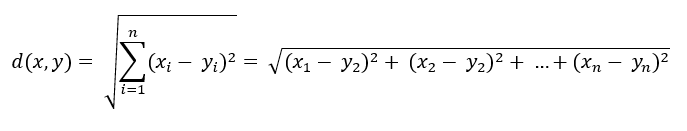
- Manhattan distance: the sum of the absolute values of differences between the components of x and y coordinates:
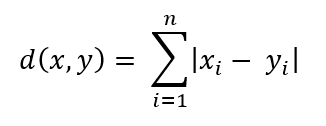
- Minkowski distance is the generalization of the above two techniques. It has a parameter *p* that takes a value of either 1 or 2. When *p=1*, formula becomes manhattan distance, and *p=2* for euclidean:
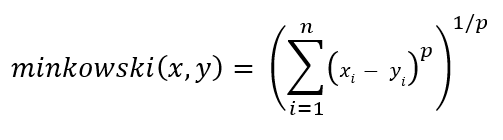

Sorry for the fancy formulas, but you might as well get used to it if you are going to learn machine learning further on.

> The lack of training phase also means that the algorithm does not *generalize*.

Next, kNN is also a *non-parametric* algorithm - it does not have strict requirements on the shape and distribution of your data. Unlike linear regression, which assumes your features and target have a linear relationship, kNN makes no such assumptions. That's why it is considered as one of the easiest models out there and works pretty well out-of-the-box if trained on 'appropriate' data. (And I explain what I mean by 'appropriate' in a later section)

### How to Choose the Value of *k*

I think you have already realized that the results of the algorithm entirely depends on the value of *k*. So, the obvious question is "How do we choose the optimal number for *k*?"

Unfortunately, there is no clear-cut answer. The optimal value changes for every dataset. Your job is to find out the *k* that maximizes your performance metric, e.g. accuracy. However, there are some general trends you can follow to make smart choices for the possible values of *k*.

Firstly, choosing a small value of *k* will lead to overfitting. For example, when *k=1* kNN classifier labels the new sample with the same label as the nearest neighbor. Such classifier will perform terribly at testing. In contrast, choosing a large value will lead to underfitting and will be computationally expensive.

You can think of this in the context of real neighbors. A guy named Jack lives in his hometown all his life and has known his neighbors for a long time. If he moves to a new city, he suddenly becomes a complete stranger and has no way of getting to know his new neighbors quickly. That is, in a sense, overfitting.

In contrast, Jack's son - Jon, is only 6 years old and is too you to know much about their neighbors. When their family moves, Jon neither knows his old neighbors well or his new neighbors. This can be thought of underfitting, an algorithm too dumb to understand the trends in both the training and test sets. 

Now, there is a completely another person - Bruce, who is very friendly, sociable, travels a lot and knows many languages. Wherever he moves he quickly becomes good friends with everyone around him. In this analogy, Bruce's qualities can be thought as the best parameters of an algorithm.

This example might not make any sense to you whatsoever, but everyone has their own version of interpreting of what is overfitting and underfitting. Important thing is that you understand how the performance of kNN changes as you play around with different values of K. 

In practice, you would use tools like `GridSearchCV` to choose the number of neighbors but that is a little out the of the scope of this post. Instead, we will choose the optimal number visually with model complexity curves.

### Classification With KNeighborsClassifier

As I said earlier, for classification problems, the label of a new sample is identified by the majority of the votes in the nearest *k* neighbors. Let's see the algorithm in action using `sklearn`'s `KNeighborsClassifier`:
```python
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
```
We import it from `sklearn.neighbors` along with other helpful functions. All other libraries are imported under standard aliases. 

For the dataset, we will use the [Palmer Archipelago Penguins](https://www.kaggle.com/parulpandey/palmer-archipelago-antarctica-penguin-data) data from Kaggle. This dataset consists of features of 3 penguins species: Adélie, Gentoo, and Chinstrap. We will build a kNN classifier of penguin species by using their body measurements:

In [61]:
penguins = pd.read_csv('data/penguins_size.csv').dropna()
penguins.head()

,species,island,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


https://twitter.com/allison_horst/status/1270046411002753025?s=20

I mentioned that kNN does not make any assumptions about the distribution of data. Let's build our first classifier without any preprocessing. We will only use 3 columns as features: culmen length and depth, flipper length and BMI:

In [62]:
# Create features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize a model with 5 neighbors
knn = KNeighborsClassifier(n_neighbors=3)

# Fit and predict
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)

For simplicity, I chose only numerical columns. Created a test prediction with size 0.25 and fit a classifier with 3 neighbors. Let's calculate its accuracy using `accuracy_score`:

In [63]:
accuracy_score(y_test, predictions)

0.7722772277227723

We get 77% accuracy which is not ideal but a pretty good score for an out-of-the-box model.

### Regression With KNeighborsRegressor

In a regression task, which predicts continuous values (not labels), kNN takes the mean of the nearest *k* neighbors. The regressor is readily-available from `sklearn.neighbors.KNeighborsRegressor`:

In [64]:
from sklearn.neighbors import KNeighborsRegressor

This time, we will try to predict Body Mass Index of the penguins using their 3 body measurements (again, only numeric features without preprocessing):

In [65]:
# Create features and target
X = penguins.select_dtypes(exclude=['object']).drop('body_mass_g', axis=1)
y = penguins.body_mass_g

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Initialize kNN
knn = KNeighborsRegressor(n_neighbors=5)

# Fit and score
knn.fit(X_train, y_train)

knn.score(X_test, y_test)

0.7932521002013702

Setting the number of neighbors to 5 yielded a coefficient of determination of 0.79. Instead of blindly trying out random numbers for *k*, let's take a smarter approach.

### Model Complexity Curves

The idea is that we try out different values for *k* and and plot the results of our performance metric against it. This will make more sense once you see it. Let's start with our classifier:

We create a function called `plot_complexity_curve` which takes possible numbers for neighbors, the model itself and the data as arguments. Then, for each *k*, it initializes, fits and scores the given model both on training and test sets. Scoring the model both on training and test sets will give you a good idea of what values lead to overfitting and underfitting:

In [55]:
def plot_complexity_curve(k_list, knn_model, x_train, x_test, y_train, y_test):
    
    train_scores = []
    test_scores = []
    
    # For each k
    for k in k_list:
        # Initialize, fit, predict
        knn = knn_model(k)
        
        knn.fit(x_train, y_train)
        
        train_scores.append(knn.score(x_train, y_train))
        test_scores.append(knn.score(x_test, y_test))

    # Plot
    fig, ax = plt.subplots()
    
    ax.plot(k_list, train_scores, label='Training Accuracy', color='red')
    ax.plot(k_list, test_scores, label='Testing Accuracy', color='black')

    ax.set(title='k-NN with Different Values for $k$',
           xlabel='Number of Neighbors',
           ylabel='Accuracy')
    
    ax.legend()

In the function, I introduce the [`knn.score`](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) function which takes x and y values. It is just a shorter version of generating predictions using `predict` and scoring it against `y_test`. We repeat the same process of choosing numerical values as features and plug them into the function:

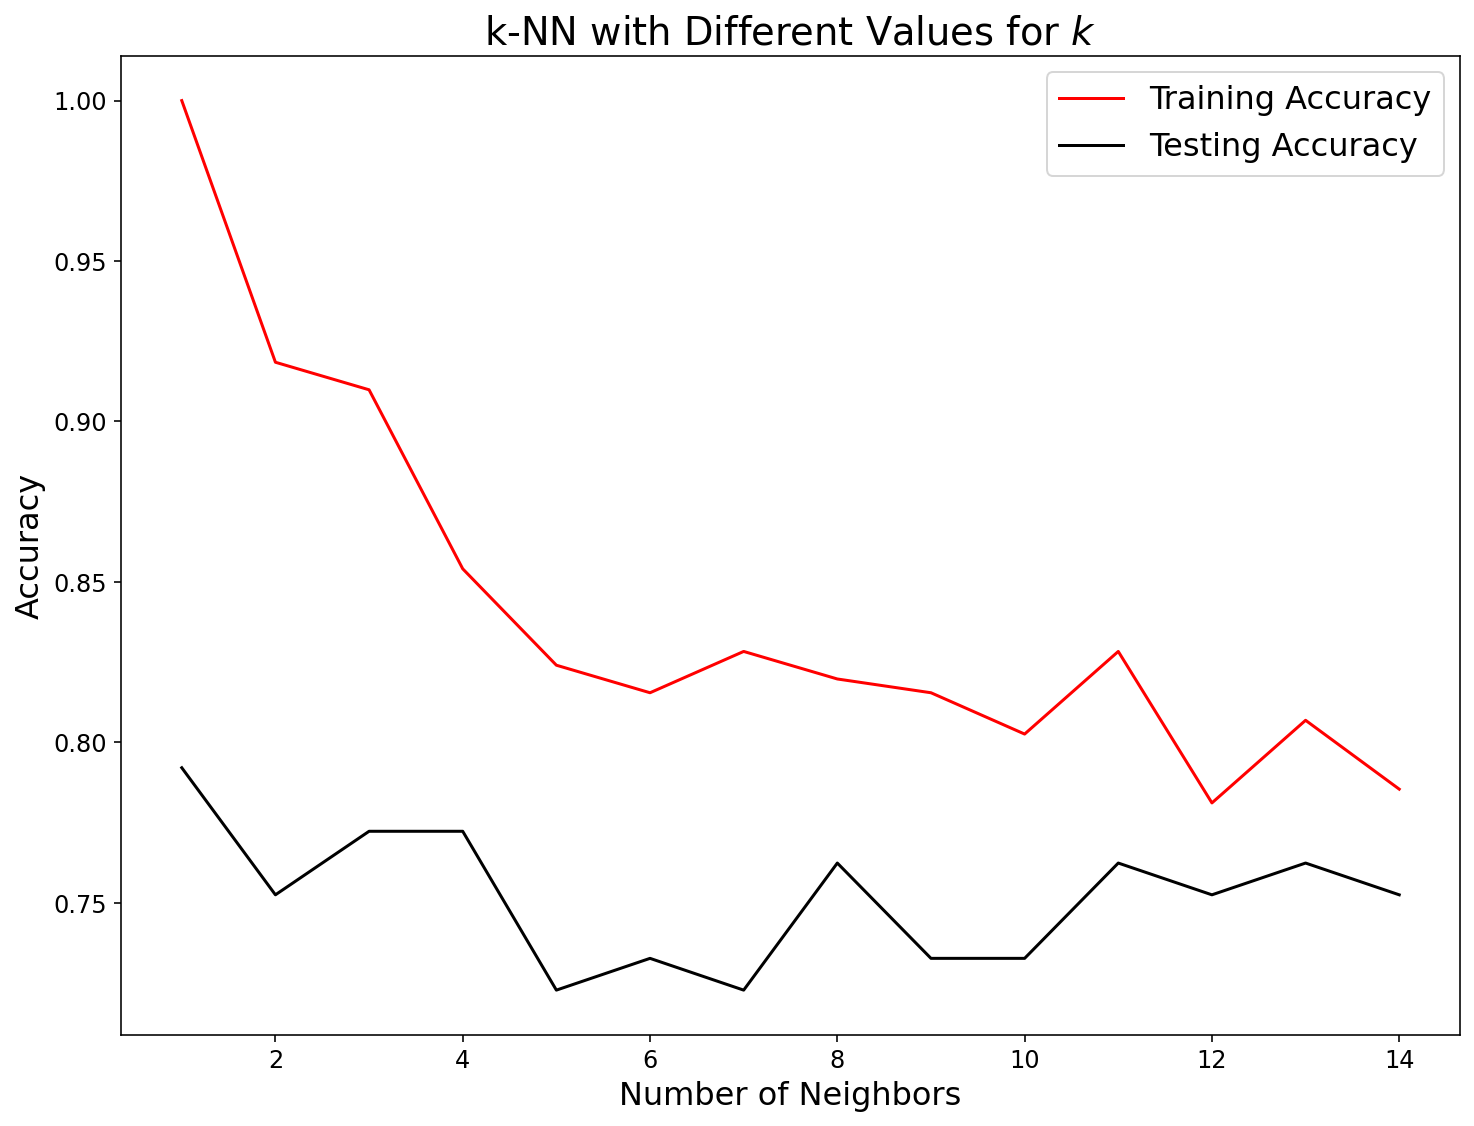

In [57]:
# Create possible values for k
neighbors = np.arange(1, 15)

# Create features and target
X = penguins.select_dtypes(exclude=['object'])
y = penguins.species

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

plot_complexity_curve(neighbors, KNeighborsClassifier, X_train, X_test, y_train, y_test)

From the plot, we can see that either 3 or 4 neighbors is the sweet middle between overfit (very high training score and low test score) and underfit (both training and test scores are low). 

Now, it is time for the regressor:

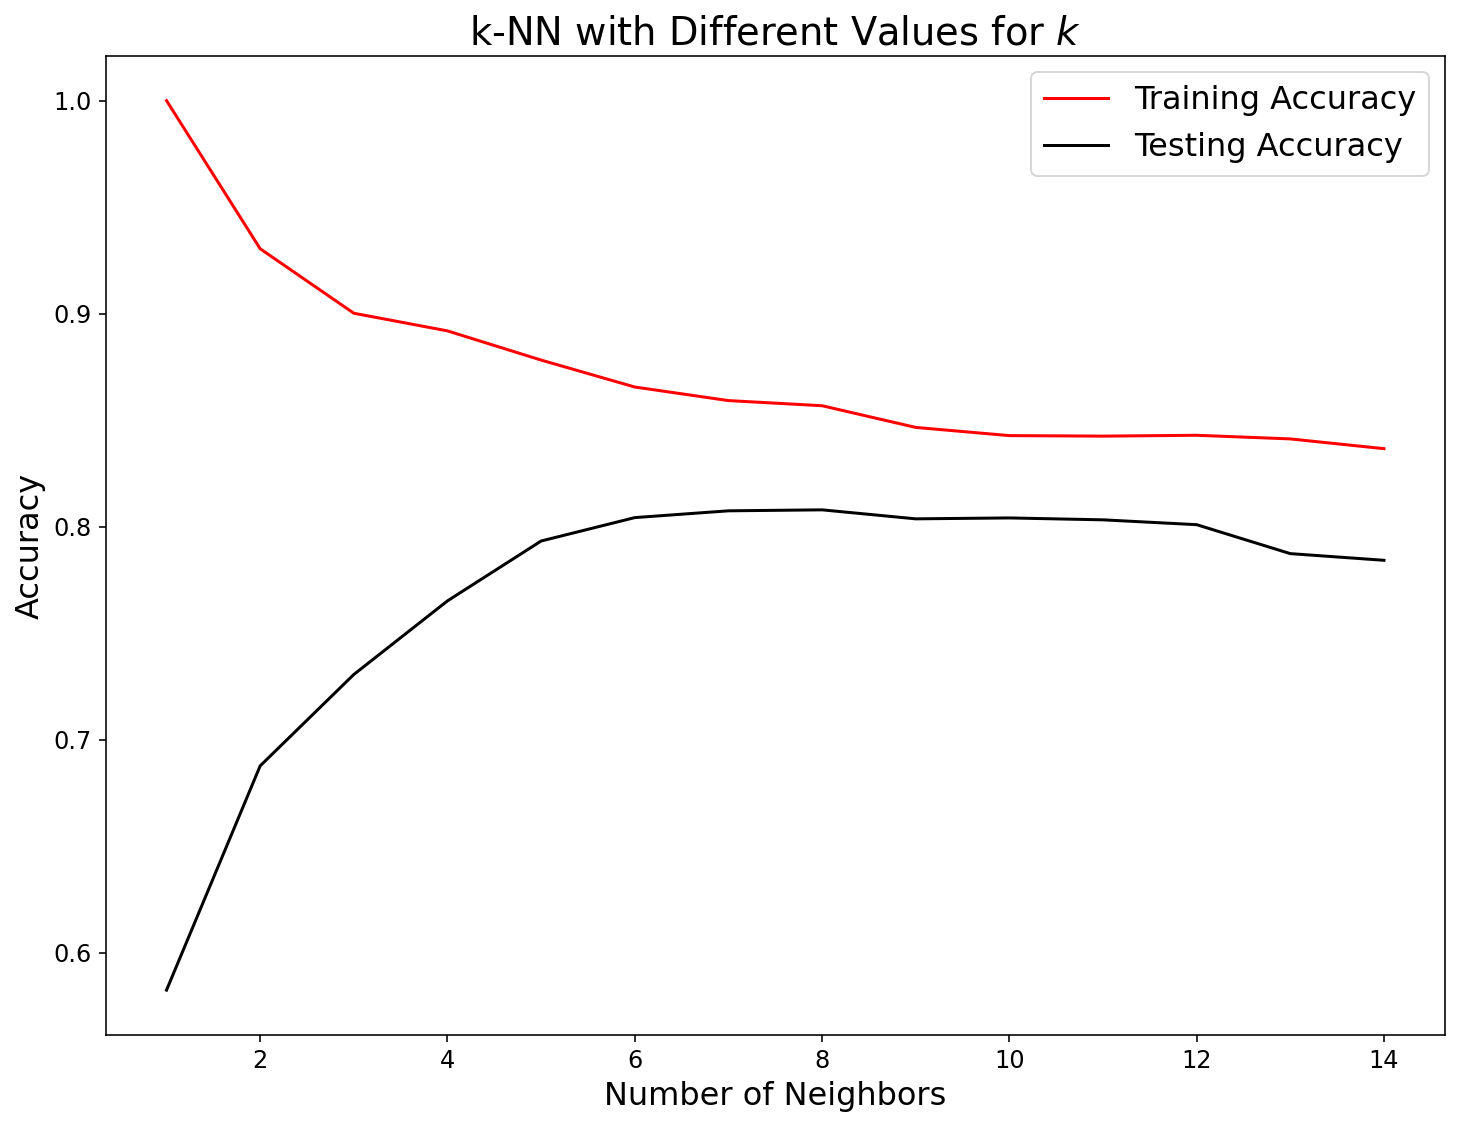

In [58]:
# Create features and target
X = penguins.select_dtypes(exclude=['object']).drop('body_mass_g', axis=1)
y = penguins.body_mass_g

# Train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

plot_complexity_curve(neighbors, KNeighborsRegressor, X_train, X_test, y_train, y_test)

For regressor, it seems that any number of neighbors between 6 and 10 is a good hyperparameter. Note that the accuracy is given as coefficient of determination - $R^2$. Read more about it on sklearn's [official docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor.score).

In both cases, there is a lot of room for improvement. There are a few preprocessing techniques which can drastically improve the performance of kNN. Let's dive into them in the next section!

### Improving the Performance of kNN, Feature Scaling

Even though we got reasonably good scores for penguins dataset, kNN is a very fussy algorithm. It has certain data quality requirements for it to work properly.

The penguins dataset is a simple dataset, a drop-in replacement for Iris. For more complexity, we will work on Diamonds dataset which is built-in to Seaborn:

In [66]:
diamonds = sns.load_dataset('diamonds')
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [105]:
diamonds['cut'].unique()

['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']
Categories (5, object): ['Ideal', 'Premium', 'Good', 'Very Good', 'Fair']

For classification, we will build a classifier that predicts a diamond's cut which is either one of 'Ideal', 'Premium', 'Good', 'Very Good', 'Fair' (Best to worst).

The first requirement of kNN is that numerical features should have the same scale. If you pay attention, diamond carat is at a very different scale than depth, table and price columns. Generally, all features should be scaled so that they range from 0 to 1. 

This can be done using a method called MinMax scaling (called normalization). It subtracts the minimum value and divides by (max - min) for each data point in the distribution:

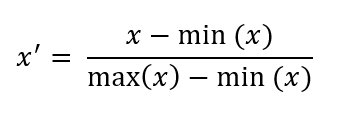

Scikit-Learn conveniently provides a `MinMaxScaler` transformer which performs this normalization to numerical columns in a pandas DataFrame:

In [68]:
from sklearn.preprocessing import MinMaxScaler

Before we apply this transformer, let's see what happens if we fit kNN classifier without preprocessing. Do you think we will be lucky like before?

In [83]:
# Create features and target
X = diamonds.select_dtypes(exclude=['category'])
y = diamonds.cut

# Fit kNN with k=7
knn = KNeighborsClassifier(n_neighbors=7)

# The usual drill
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=4)

# Fit, predict, score
knn.fit(X_train, y_train)

preds = knn.predict(X_test)

accuracy_score(y_test, preds)

0.5454826350265727

Yikes! 55% accuracy! That is definitely not what we want. Let's apply MinMax scaling to all numeric features. The general syntax is as follows:

In [88]:
# Taken from the sklearn documentation
data = pd.DataFrame([[-1, 2], [-0.5, 6], [0, 10], [1, 18]])
data

,0,1
0,-1.0,2
1,-0.5,6
2,0.0,10
3,1.0,18


In [91]:
scaler = MinMaxScaler()
scaler.fit_transform(data)

array([[0.  , 0.  ],
       [0.25, 0.25],
       [0.5 , 0.5 ],
       [1.  , 1.  ]])

After initiating the scaler with `MinMaxScaler`, we call the `fit_transform` method which returns transformed dataframe:

In [93]:
# Initiate the scaler
scaler = MinMaxScaler()

# Fit/transform to all numeric data
X_prepped = scaler.fit_transform(X)

# Create new train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_prepped, y, test_size=.3, random_state=4)

# Initialize, fit, predict
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

preds = knn.predict(X_test)

accuracy_score(y_test, preds)

0.7013966135211964

There it is! 15% improvement after feature scaling.

Note that `MinMaxScaler` is not the only option for feature scaling. In cases of outliers, don't use `MinMaxScaler`. Instead, use `StandardScaler` which scales by subtracting the mean and dividing by the standard deviation. See the [user guide](https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-scaler) of sklearn for a more detailed guide.

### Encoding Categorical Variables

Even though we improved the model a lot, there is still room for improvement. It is time we bring in categorical variables like clarity and color of the diamonds.

Most ML algorithms prefer numeric values, so we should convert all text/categorical variables to numbers. 

> With most datasets, there will be much more problems related to text/categorical values before you convert them to numbers. We will only focus on the conversion part here, but you can check out my definitive guide on cleaning text data using pandas [here](https://towardsdatascience.com/master-the-most-hated-task-in-ds-ml-3b9779276d7c#64a4):

https://towardsdatascience.com/master-the-most-hated-task-in-ds-ml-3b9779276d7c#64a4

Most popular options for encoding categorical values with numbers is sklearn's `OneHotEncoder` and `LabelEncoder`.

Label encoder assigns a new integer to each unique category in the dataset. For example, diamonds have 7 categories for color:

In [94]:
diamonds['color'].unique()

['E', 'I', 'J', 'H', 'F', 'G', 'D']
Categories (7, object): ['E', 'I', 'J', 'H', 'F', 'G', 'D']

8 categories for clarity:

In [95]:
diamonds['clarity'].unique()

['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']
Categories (8, object): ['SI2', 'SI1', 'VS1', 'VS2', 'VVS2', 'VVS1', 'I1', 'IF']

Label encoder works best for ordinal variables - categories with order. Looking at the documentation of the dataset, there is a clear ordering for both color and clarity. We should specify the ordering before applying `LabelEncoder`:

In [103]:
# Order color from J (worst) to D (best)
diamonds['color'] = pd.Categorical(diamonds['color'], ordered=True,
                                  categories=['J', 'I', 'H', 'G', 'F', 'E', 'D'])

# Order clarity from I1 (worst) to IF (best)
diamonds['clarity'] = pd.Categorical(diamonds['clarity'], ordered=True,
                                    categories=['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'])

We order the colors from 'J' to 'D' and clarity from 'I1' to 'IF', both from worst to best so that we get labels starting from 0 for the worst category.